# Example Notebook
### Building a CNN for image recognition

# Introduction
CNN's are really good at image recognition. Here we perform a standard object recognition test using the cifar10 dataset:

In [1]:
%matplotlib inline

#import data (code gegeven)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

print(train_images.shape)
print(train_labels.shape)

170498071/170498071 [==============================] - 107s 1us/step
(50000, 32, 32, 3)
(50000, 1)


## Running the model locally from VS code
Now fit a model and show the accuracy over time:

In [3]:
import pandas as pd

def plot_accuracy(history):
    return pd.DataFrame({"Accuracy":history.history['accuracy'], 
                         "Validation accuracy":history.history['val_accuracy']}).plot(xlabel = 'Epoch')

Epoch 1/5
1563/1563 [==============================] - 17s 8ms/step - loss: 1.8066 - accuracy: 0.3391 - val_loss: 1.3974 - val_accuracy: 0.5069
Epoch 2/5
1563/1563 [==============================] - 12s 7ms/step - loss: 1.3438 - accuracy: 0.5136 - val_loss: 1.0787 - val_accuracy: 0.6125
Epoch 3/5
1563/1563 [==============================] - 12s 7ms/step - loss: 1.1470 - accuracy: 0.6007 - val_loss: 0.9849 - val_accuracy: 0.6758
Epoch 4/5
1563/1563 [==============================] - 12s 7ms/step - loss: 1.0190 - accuracy: 0.6496 - val_loss: 0.8019 - val_accuracy: 0.7188
Epoch 5/5
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9165 - accuracy: 0.6891 - val_loss: 0.8373 - val_accuracy: 0.7202


<AxesSubplot:xlabel='Epoch'>

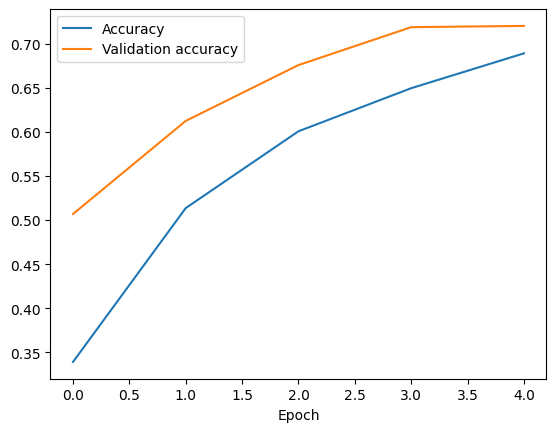

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_images, test_images = train_images / 255.0, test_images / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

data_flow = train_datagen.flow(train_images, tf.reshape(train_labels, (-1)), shuffle=True)

model = models.Sequential([
    layers.Conv2D(32, (3,3) , activation="relu", input_shape=(32,32,3), padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3) , activation="relu", padding='same') ,
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="ADAM",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

history=model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_data=(test_images, test_labels))

plot_accuracy(history)

## Reading the results from a previous run stored from the server
On the much more powerful server we ran `train.py` which ended up [dumping a fitted model](https://www.tensorflow.org/guide/keras/save_and_serialize) (`fitted_model/`) and a history file stored in pickle. First we pick up the model: 

In [8]:
from keras.models import load_model

server_model = load_model('fitted_model')

If we read the history file, we can also have a look at the accuracy and validated accuracy:

<AxesSubplot:xlabel='Epoch'>

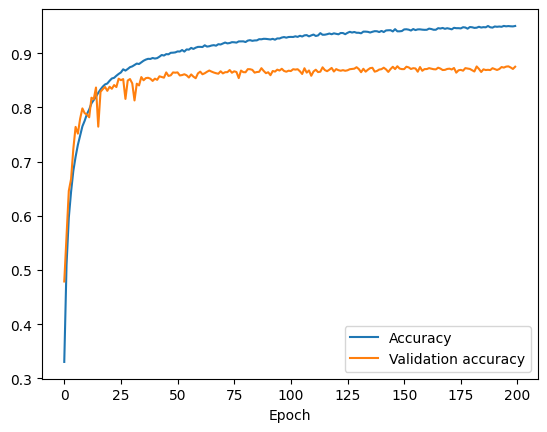

In [7]:
from pickle import load

with open(r"train_history.pkl", "rb") as server_history_file:
        server_history = load(server_history_file)

plot_accuracy(server_history)

# Working with MLFlow
Instead of manually tracking all kinds of data, we can also use the MLFlow library to do this work for us. The file `train_mlflow.py` includes the code to track the experiments you run. Note that for now they are stored in the `mlruns` subdirectory, and ignored by git as this gets quite large quite quickly. Also notice that the code to start tracking Keras models is very short:

    mlflow.tensorflow.autolog()

starts tracking the most important metrics. 